## E13B Tesseract MICR: OCR

Dataset Source: https://github.com/DoubangoTelecom/tesseractMICR/tree/master/datasets/e13b

#### Import Necessary Libraries

In [1]:
import os, sys, itertools, glob
os.environ['TOKENIZERS_PARALLELISM']='false'

import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset

import datasets
from datasets import load_dataset

import sklearn
from sklearn.model_selection import train_test_split

import transformers
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import VisionEncoderDecoderModel, TrOCRProcessor, default_data_collator

import evaluate

!git lfs install

Git LFS initialized.


#### Display Versions of Relevant Software & Libraries

In [2]:
print("Python:".rjust(15), sys.version[0:6])
print("Pandas:".rjust(15), pd.__version__)
print("Datasets:".rjust(15), datasets.__version__)
print("Torch:".rjust(15), torch.__version__)
print("Transformers:".rjust(15), transformers.__version__)
print("Evaluate:".rjust(15), evaluate.__version__)
print("Sklearn:".rjust(15), sklearn.__version__)

        Python: 3.9.12
        Pandas: 2.0.3
      Datasets: 2.13.1
         Torch: 2.0.1
  Transformers: 4.28.1
      Evaluate: 0.4.0
       Sklearn: 1.3.0


#### Ingest & Preprocess Training Dataset

In [3]:
parent_dir = "/Users/briandunn/Desktop/TrOCR/datasets/e13b/"
tif_files = glob.glob(parent_dir + "*.tif")
txt_files = glob.glob(parent_dir + "*.txt")

# Create dataframe of each list 
tif_df = pd.DataFrame(tif_files, columns=['file_name'])
txt_df = pd.DataFrame(txt_files, columns=['text_file'])

# Then create new column with the integer value at the value
tif_df['sample_id'] = tif_df['file_name'].apply(lambda x: x.split(".")[0].split("_")[-1])
txt_df['sample_id'] = txt_df['text_file'].apply(lambda x: x.split(".")[0].split("_")[-1])

# Make all paths relative (to this directory)
tif_df['file_name'] = tif_df['file_name'].apply(lambda x: x.split("/e13b/")[-1])

# set index for concatenation
tif_df = tif_df.set_index(keys='sample_id')
txt_df = txt_df.set_index(keys='sample_id')

# concatenate the two dataframes based on that column
df = pd.concat([tif_df, txt_df], axis=1, join='inner')

df = df.dropna()

df = df.drop_duplicates()

df = df.reset_index(drop=True)

df

,file_name,text_file
0,tesseract_e13b_font_generator_00005175.tif,/Users/briandunn/Desktop/TrOCR/datasets/e13b/t...
1,tesseract_e13b_font_generator_00003504.tif,/Users/briandunn/Desktop/TrOCR/datasets/e13b/t...
2,reallife_cgi_1212995877-0.tif,/Users/briandunn/Desktop/TrOCR/datasets/e13b/r...
3,tesseract_e13b_font_generator_00001313.tif,/Users/briandunn/Desktop/TrOCR/datasets/e13b/t...
4,tesseract_e13b_font_generator_00001475.tif,/Users/briandunn/Desktop/TrOCR/datasets/e13b/t...
...,...,...
8401,reallife_gi_1200254629-0.tif,/Users/briandunn/Desktop/TrOCR/datasets/e13b/r...
8402,tesseract_e13b_font_generator_00000014.tif,/Users/briandunn/Desktop/TrOCR/datasets/e13b/t...
8403,reallife_cgi_1212994160-0.tif,/Users/briandunn/Desktop/TrOCR/datasets/e13b/r...
8404,tesseract_e13b_font_generator_00004272.tif,/Users/briandunn/Desktop/TrOCR/datasets/e13b/t...


#### Convert Text File Names to Text Contained In Files

In [4]:
def replace_file_name_with_contents(file_path):
    with open(file_path, 'r') as file:
        return file.read()

df['text'] = df['text_file'].apply(replace_file_name_with_contents)

df = df.drop(columns=['text_file'])

df

,file_name,text
0,tesseract_e13b_font_generator_00005175.tif,C990809C D413562705 85045121246156C
1,tesseract_e13b_font_generator_00003504.tif,B98132429B
2,reallife_cgi_1212995877-0.tif,C000179C066D005A
3,tesseract_e13b_font_generator_00001313.tif,C562551C
4,tesseract_e13b_font_generator_00001475.tif,C571912C
...,...,...
8401,reallife_gi_1200254629-0.tif,C950020C452259002A002860C31
8402,tesseract_e13b_font_generator_00000014.tif,D512579177
8403,reallife_cgi_1212994160-0.tif,C329479C009D0191A010896005
8404,tesseract_e13b_font_generator_00004272.tif,C183453C A201894917A 52608092887C...


#### Clean Up Text/Labels

In [5]:
# Replace all letters with spaces
df['text'] = df['text'].str.replace('[a-zA-Z]', ' ', regex=True)

# Then replace all instances of multiple 
# consecutive spaces with single space
df['text'] = df['text'].apply(lambda x: ' '.join(x.split()))

# Remove all leading & trailing whitespace
df['text'] = df['text'].apply(lambda x: x.strip())

df.head()

,file_name,text
0,tesseract_e13b_font_generator_00005175.tif,990809 413562705 85045121246156
1,tesseract_e13b_font_generator_00003504.tif,98132429
2,reallife_cgi_1212995877-0.tif,000179 066 005
3,tesseract_e13b_font_generator_00001313.tif,562551
4,tesseract_e13b_font_generator_00001475.tif,571912


#### Visualize: Histogram of Text Lengths

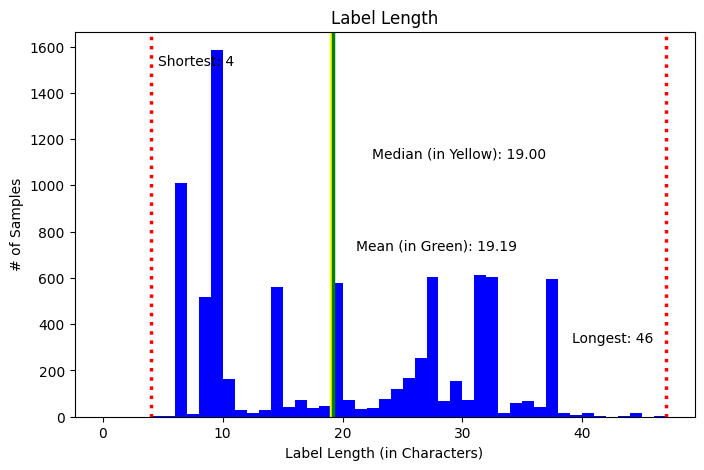

The string values range from 4 to 46 characters.


In [6]:
df['label_len'] = df['text'].str.len()

MIN_LENGTH_VALUE = min(df['label_len'])
MAX_LENGTH_VALUE = max(df['label_len'])
LENGTH_VALUE_MEAN = df['label_len'].mean()
LENGTH_VALUE_MEDIAN = df['label_len'].median()

graph_y_max = 1600

df.hist("label_len", 
        grid=False, 
        color="Blue", 
        figsize=(8,5), 
        bins=MAX_LENGTH_VALUE + 1,
        range=(0, MAX_LENGTH_VALUE + 1)
        )

plt.suptitle('')
plt.xlabel('Label Length (in Characters)')
plt.ylabel('# of Samples')
plt.title('Label Length')

# Display & label vertical line @ minimum value
plt.axvline(MIN_LENGTH_VALUE, color='red', linestyle='dotted', linewidth=2.5)
plt.text(MIN_LENGTH_VALUE * 1.15, graph_y_max * 0.95, 'Shortest: {:.0f}'.format(MIN_LENGTH_VALUE))

# Display & label vertical line @ maximum value
plt.axvline(MAX_LENGTH_VALUE + 1, color='red', linestyle='dotted', linewidth=2.5)
plt.text(MAX_LENGTH_VALUE * 0.85, graph_y_max * 0.20, 'Longest: {:.0f}'.format(MAX_LENGTH_VALUE))

# Display & label vertical line @ median value
plt.axvline(LENGTH_VALUE_MEDIAN, color='yellow', linestyle='solid', linewidth=2.5)
plt.text(LENGTH_VALUE_MEDIAN * 1.18, graph_y_max * 0.70, 'Median (in Yellow): {:.2f}'.format(LENGTH_VALUE_MEDIAN))

# Display & label vertical line @ mean value
plt.axvline(LENGTH_VALUE_MEAN, color='green', linestyle='solid', linewidth=2.5)
plt.text(LENGTH_VALUE_MEAN * 1.10, graph_y_max * 0.45, 'Mean (in Green): {:.2f}'.format(LENGTH_VALUE_MEAN))

plt.show()

print(f"The string values range from {MIN_LENGTH_VALUE} to {MAX_LENGTH_VALUE} characters.")

df = df.drop(columns=['label_len'])

#### Split Dataset into Training & Testing Datasets

In [7]:
train_df, test_df = train_test_split(df, 
                                     test_size=0.20, 
                                     random_state=42)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"Training Dataset Shape: {train_df.shape}")
print(f"Testing Dataset Shape: {test_df.shape}")

Training Dataset Shape: (6724, 2)
Testing Dataset Shape: (1682, 2)


#### Create Dataset Class

In [8]:
class E13b_Tesseract_MICR_OCR_Dataset(Dataset):
    
    def __init__(self, 
                 root_dir, 
                 df, 
                 processor, 
                 max_target_length=48):
        
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        # prepare image (i.e. resize + normalize)
        image = Image.open(self.root_dir + file_name).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        # add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                          padding="max_length", 
                                          max_length=self.max_target_length
                                          ).input_ids
        # important: make sure that PAD tokens are ignored by loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id 
                  else -100 for label in labels]
        
        encoding = {"pixel_values" : pixel_values.squeeze(), "labels" : torch.tensor(labels)}
        return encoding

##### Basic Values/Constants

In [9]:
MODEL_CKPT = "microsoft/trocr-large-printed"
MODEL_NAME =  MODEL_CKPT.split("/")[-1] + "-e13b_tesseract_MICR_ocr"

NUM_OF_EPOCHS = 2
REPORTS_TO = "tensorboard"

STRATEGY = "epoch"
DEVICE = torch.device("cpu")

##### Instantiate Processor, Create Training, & Testing Dataset Instances

In [10]:
parent_dir = "/Users/briandunn/Desktop/TrOCR/datasets/e13b/"

image_processor = TrOCRProcessor.from_pretrained(MODEL_CKPT)

train_ds = E13b_Tesseract_MICR_OCR_Dataset(root_dir=parent_dir,
                                           df=train_df,
                                           processor=image_processor)

test_ds = E13b_Tesseract_MICR_OCR_Dataset(root_dir=parent_dir,
                                          df=test_df,
                                          processor=image_processor)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


##### Print Length of Training & Testing Datasets

In [11]:
print(f"The training dataset has {len(train_ds)} samples in it.")
print(f"The testing dataset has {len(test_ds)} samples in it.")

The training dataset has 6724 samples in it.
The testing dataset has 1682 samples in it.


##### Example of Input Data Shapes

In [12]:
encoding = train_ds[0]

for k,v in encoding.items():
    print(k.rjust(12, " "), ":", v.shape)

pixel_values : torch.Size([3, 384, 384])
      labels : torch.Size([48])


##### Show Example

/Users/briandunn/Desktop/TrOCR/datasets/e13b/tesseract_e13b_font_generator_00002747.tif


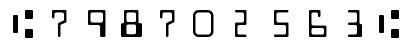

In [13]:
print(train_ds.root_dir + train_df['file_name'][0])

image = Image.open(train_ds.root_dir + train_df['file_name'][0]).convert("RGB")

image

##### Show Label for Above Example

In [14]:
labels = encoding['labels']
labels[labels == -100] = image_processor.tokenizer.pad_token_id
label_str = image_processor.decode(labels, skip_special_tokens=True)
print(label_str)

798702563


#### Instantiate Model

In [15]:
model = VisionEncoderDecoderModel.from_pretrained(MODEL_CKPT).to(DEVICE)

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


##### Model Configuration Modifications

In [16]:
model.config.decoder_start_token_id = image_processor.tokenizer.cls_token_id
model.config.pad_token_id = image_processor.tokenizer.pad_token_id

model.config.vocab_size = model.config.decoder.vocab_size

model.config.eos_token_id = image_processor.tokenizer.sep_token_id
model.config.max_length = MAX_LENGTH_VALUE
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 0
model.config.num_beams = 8

##### Define Metrics Evaluation

In [17]:
cer_metric = evaluate.load("cer")

def compute_metrics(pred):
    label_ids = pred.label_ids
    pred_ids = pred.predictions
    
    pred_str = image_processor.batch_decode(pred_ids, skip_special_tokens=True)
    label_ids[label_ids == -100] = image_processor.tokenizer.pad_token_id
    label_str = image_processor.batch_decode(label_ids, skip_special_tokens=True)
    
    cer = cer_metric.compute(predictions=pred_str, references=label_str)
    
    return {"cer" : cer}

#### Define Training Arguments

In [18]:
args = Seq2SeqTrainingArguments(
    output_dir = MODEL_NAME,
    num_train_epochs=NUM_OF_EPOCHS,
    predict_with_generate=True,
    evaluation_strategy=STRATEGY,
    save_strategy=STRATEGY,
    logging_strategy="steps",
    logging_steps=29,
    logging_first_step=True,
    report_to=REPORTS_TO,
    auto_find_batch_size=True,
    hub_private_repo=True,
    push_to_hub=True
)

##### Define Trainer

In [19]:
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=image_processor.feature_extractor,
    args=args,
    compute_metrics=compute_metrics,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    data_collator=default_data_collator
)

/Users/briandunn/Desktop/python_venvs/torch_cv/lib/python3.9/site-packages/transformers/models/trocr/processing_trocr.py:134: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
Cloning https://huggingface.co/DunnBC22/trocr-large-printed-e13b_tesseract_MICR_ocr into local empty directory.


##### Fit/Train Model

In [20]:
train_results = trainer.train()

/Users/briandunn/Desktop/python_venvs/torch_cv/lib/python3.9/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1682 [00:00<?, ?it/s]

{'loss': 9.5696, 'learning_rate': 4.9970273483947685e-05, 'epoch': 0.0}
{'loss': 2.0231, 'learning_rate': 4.913793103448276e-05, 'epoch': 0.03}
{'loss': 1.2689, 'learning_rate': 4.827586206896552e-05, 'epoch': 0.07}
{'loss': 1.1252, 'learning_rate': 4.741379310344828e-05, 'epoch': 0.1}
{'loss': 1.0745, 'learning_rate': 4.655172413793104e-05, 'epoch': 0.14}
{'loss': 1.1696, 'learning_rate': 4.5689655172413794e-05, 'epoch': 0.17}
{'loss': 1.0006, 'learning_rate': 4.482758620689655e-05, 'epoch': 0.21}
{'loss': 1.0273, 'learning_rate': 4.396551724137931e-05, 'epoch': 0.24}
{'loss': 1.1105, 'learning_rate': 4.3103448275862066e-05, 'epoch': 0.28}
{'loss': 1.2629, 'learning_rate': 4.224137931034483e-05, 'epoch': 0.31}
{'loss': 0.9306, 'learning_rate': 4.1379310344827587e-05, 'epoch': 0.34}
{'loss': 0.9233, 'learning_rate': 4.0517241379310344e-05, 'epoch': 0.38}
{'loss': 0.9108, 'learning_rate': 3.965517241379311e-05, 'epoch': 0.41}
{'loss': 0.9462, 'learning_rate': 3.8793103448275865e-05, 'ep

/Users/briandunn/Desktop/python_venvs/torch_cv/lib/python3.9/site-packages/transformers/generation/utils.py:1219: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(


  0%|          | 0/211 [00:00<?, ?it/s]

{'eval_loss': 0.5168413519859314, 'eval_cer': 0.042814229249011855, 'eval_runtime': 53945.1969, 'eval_samples_per_second': 0.031, 'eval_steps_per_second': 0.004, 'epoch': 1.0}
{'loss': 0.4464, 'learning_rate': 2.413793103448276e-05, 'epoch': 1.03}
{'loss': 0.4375, 'learning_rate': 2.327586206896552e-05, 'epoch': 1.07}
{'loss': 0.411, 'learning_rate': 2.2413793103448276e-05, 'epoch': 1.1}
{'loss': 0.4487, 'learning_rate': 2.1551724137931033e-05, 'epoch': 1.14}
{'loss': 0.388, 'learning_rate': 2.0689655172413793e-05, 'epoch': 1.17}
{'loss': 0.4448, 'learning_rate': 1.9827586206896554e-05, 'epoch': 1.21}
{'loss': 0.5106, 'learning_rate': 1.896551724137931e-05, 'epoch': 1.24}
{'loss': 0.3352, 'learning_rate': 1.810344827586207e-05, 'epoch': 1.28}
{'loss': 0.3674, 'learning_rate': 1.7241379310344828e-05, 'epoch': 1.31}
{'loss': 0.3654, 'learning_rate': 1.6379310344827585e-05, 'epoch': 1.34}
{'loss': 0.3391, 'learning_rate': 1.5517241379310346e-05, 'epoch': 1.38}
{'loss': 0.3538, 'learning_r

  0%|          | 0/211 [00:00<?, ?it/s]

{'eval_loss': 0.24321582913398743, 'eval_cer': 0.0036363636363636364, 'eval_runtime': 55499.6966, 'eval_samples_per_second': 0.03, 'eval_steps_per_second': 0.004, 'epoch': 2.0}


Adding files tracked by Git LFS: ['.DS_Store']. This may take a bit of time if the files are large.


{'train_runtime': 257236.9869, 'train_samples_per_second': 0.052, 'train_steps_per_second': 0.007, 'train_loss': 0.6093255166633234, 'epoch': 2.0}


##### Save Model & Training Metrics

In [21]:
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 1.00/2.27G [00:00<?, ?B/s]

Upload file runs/Jul21_19-16-25_Brians-Mac-mini/events.out.tfevents.1689984990.Brians-Mac-mini.91332.0:   0%| …

Upload file .DS_Store:   0%|          | 1.00/6.00k [00:00<?, ?B/s]

To https://huggingface.co/DunnBC22/trocr-large-printed-e13b_tesseract_MICR_ocr
   ac47c9b..d71616b  main -> main

To https://huggingface.co/DunnBC22/trocr-large-printed-e13b_tesseract_MICR_ocr
   d71616b..141785f  main -> main



***** train metrics *****
  epoch                    =                 2.0
  train_loss               =              0.6093
  train_runtime            = 2 days, 23:27:16.98
  train_samples_per_second =               0.052
  train_steps_per_second   =               0.007


##### Push Model to Hub (My Profile!!!)

In [22]:
kwargs = {
    "finetuned_from" : model.config._name_or_path,
    "tasks" : "image-to-text",
    "tags" : ["image-to-text"],
}

if args.push_to_hub:
    trainer.push_to_hub("All Dunn!!!")
else:
    trainer.create_model_card(**kwargs)

To https://huggingface.co/DunnBC22/trocr-large-printed-e13b_tesseract_MICR_ocr
   141785f..9e58f8a  main -> main



### Notes & Other Takeaways From This Project

****
- As this dataset had over 2.5 times as many samples as the CMC7 dataset, I was expecting better results; I was not disappointed.
- FYI: In one of the other TrOCR projects that I have completed, I have a template for how to run inference on samples. It only takes a few updates/modifications (for class and variable names) to make it work for this model.

****

### Citations

- Model Checkpoint
  > @misc{li2021trocr, title={TrOCR: Transformer-based Optical Character Recognition with Pre-trained Models}, author={Minghao Li and Tengchao Lv and Lei Cui and Yijuan Lu and Dinei Florencio and Cha Zhang and Zhoujun Li and Furu Wei}, year={2021}, eprint={2109.10282}, archivePrefix={arXiv}, primaryClass={cs.CL}
}

- Metric (Character Error Rate [CER])
  > @inproceedings{morris2004,
author = {Morris, Andrew and Maier, Viktoria and Green, Phil},
year = {2004},
month = {01},
pages = {},
title = {From WER and RIL to MER and WIL: improved evaluation measures for connected speech recognition.}
}